In [23]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
import calendar
from datetime import datetime, timedelta
import warnings

In [7]:
# 解决matplotlib中文字体的问题

# import matplotlib
# import matplotlib.font_manager

# print(matplotlib.matplotlib_fname())

# # matplotlib.font_manager._rebuild()

/Users/nora/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc


# 数据加载

In [2]:
data = pd.read_csv('shanghai_index_1990_12_19_to_2020_03_12.csv', usecols=['Timestamp', 'Price'])

data.Timestamp = pd.to_datetime(data.Timestamp)
data = data.set_index('Timestamp')

data['Price'] = data['Price'].apply(pd.to_numeric, errors='ignore')

data.head()

,Price
Timestamp,
1990-12-19,99.98
1990-12-20,104.39
1990-12-21,109.13
1990-12-24,114.55
1990-12-25,120.25


# Data visualisation

In [5]:
# 按照月，季度，年来统计
df_month = data.resample('M').mean()
df_month.head()

,Price
Timestamp,
1990-12-31,116.990000
1991-01-31,132.628182
1991-02-28,131.887778
1991-03-31,126.011429
1991-04-30,118.426818


In [10]:
df_quater = data.resample('Q-DEC').mean()
df_year = data.resample('A-DEC').mean()

df_quater.head()

,Price
Timestamp,
1990-12-31,116.990000
1991-03-31,130.131803
1991-06-30,117.945625
1991-09-30,160.548030
1991-12-31,240.092656


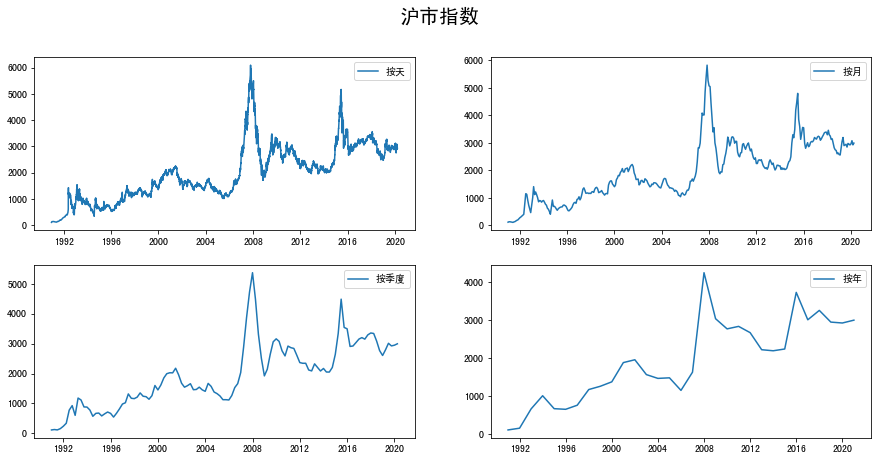

In [9]:
# 按照天，月，季度，年来显示沪市指数的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

plt.suptitle('沪市指数', fontsize=20)

plt.subplot(221)
plt.plot(data.Price, '-', label='按天')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Price, '-', label='按月')
plt.legend()

plt.subplot(223)
plt.plot(df_quater.Price, '-', label='按季度')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Price, '-', label='按年')
plt.legend()

plt.show()

# Seasonal decompose

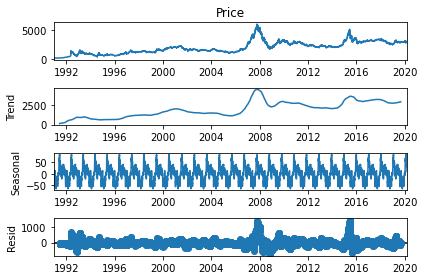

In [3]:
# 进行线性插补缺漏值
data.Price.interpolate(inplace=True)

#  返回三个部分 trend（趋势），seasonal（季节性）和residual (残留)
#  period=250: 股票交易日一年约为250天
result = sm.tsa.seasonal_decompose(data.Price, period=250)
result.plot()
plt.show()

# ARMA

In [18]:
from statsmodels.tsa.arima_model import ARMA, ARIMA

In [17]:
warnings.filterwarnings('ignore')

# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)

# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷

for param in parameters_list:
    try:
        # 选取的是按月resample后的数据
        model = ARMA(df_month.Price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
print('最优模型: ', best_model.summary())

参数错误: (0, 2)
最优模型:                                ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  352
Model:                     ARMA(2, 2)   Log Likelihood               -2290.943
Method:                       css-mle   S.D. of innovations            161.347
Date:                Fri, 24 Sep 2021   AIC                           4593.887
Time:                        01:24:15   BIC                           4617.069
Sample:                    12-31-1990   HQIC                          4603.112
                         - 03-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1884.7535    497.823      3.786      0.000     909.039    2860.468
ar.L1.Price     0.4820      0.129      3.726      0.000       0.228       0.735
ar.L2.Price     0.4832      

# ARIMA / SARIMAX - 运行快，效果不错，适合做baseline

In [55]:
# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 2)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)

# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷

for param in parameters_list:
    try:
        # 选取的是按月resample后的数据
        # model = ARIMA(df_month.Price,order=(param[0], param[1], param[2])).fit()
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = sm.tsa.statespace.SARIMAX(df_month.Price,
                                order=(param[0], param[1], param[2]),
                                #seasonal_order=(4, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
# 输出最优模型
print('最优参数: ', best_param)
print('最优模型: ', best_model.summary())

最优参数:  (1, 1, 4)
最优模型:                                 SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  352
Model:               SARIMAX(1, 1, 4)   Log Likelihood               -2249.762
Date:                Mon, 27 Sep 2021   AIC                           4511.524
Time:                        23:31:40   BIC                           4534.603
Sample:                    12-31-1990   HQIC                          4520.714
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5618      0.163      3.454      0.001       0.243       0.881
ma.L1         -0.2268      0.164     -1.381      0.167      -0.549       0.095
ma.L2         -0.0453      0

date_list= [Timestamp('2020-04-30 00:00:00', freq='M'), Timestamp('2020-05-31 00:00:00', freq='M'), Timestamp('2020-06-30 00:00:00', freq='M')]


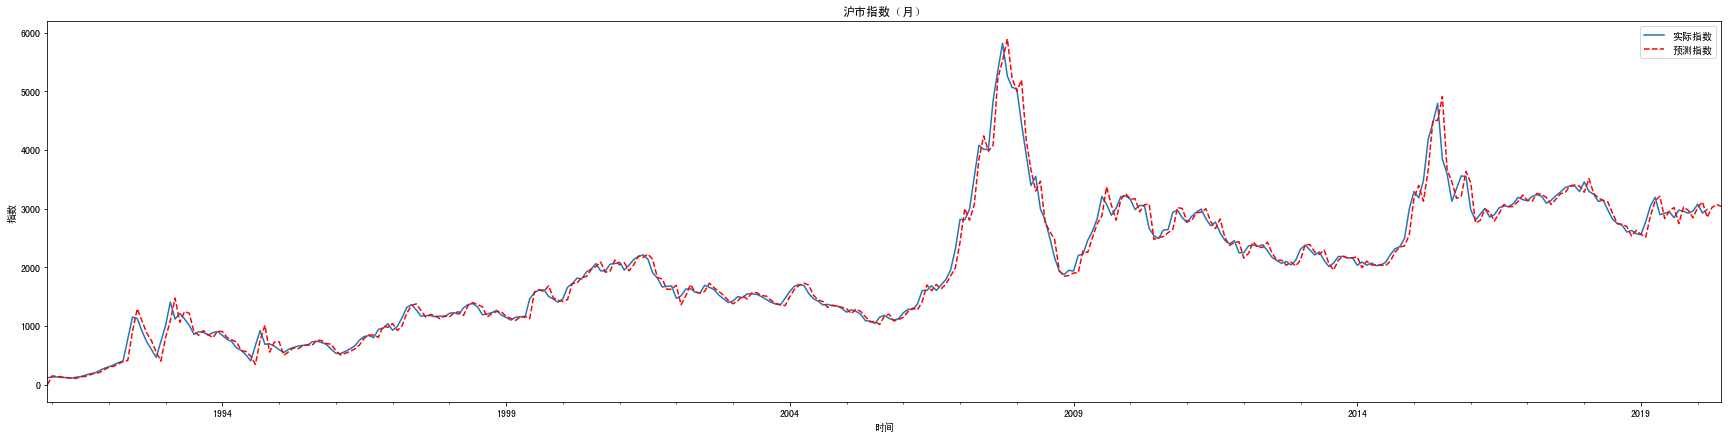

In [24]:
# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])

# get_prediction得到的是区间，使用predicted_mean
df_month2['forecast'] = best_model.get_prediction(start=0, end=len(df_month2)).predicted_mean

# 沪市指数预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='实际指数')
df_month2.forecast.plot(color='r', ls='--', label='预测指数')
plt.legend()
plt.title('沪市指数（月）')
plt.xlabel('时间')
plt.ylabel('指数')
plt.show()

# LSTM - 训练慢，feature更多，学习空间更大

In [33]:
# 使用LSTM预测沪市指数
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas import DataFrame
from pandas import concat
from itertools import chain
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [44]:
# 转化为可以用于监督学习的数据
def get_train_set(data_set, timesteps_in, timesteps_out=1):
    train_data_set = np.array(data_set)
    reframed_train_data_set = np.array(series_to_supervised(train_data_set, timesteps_in, timesteps_out).values)
    print(reframed_train_data_set)
    print(reframed_train_data_set.shape)
    train_x, train_y = reframed_train_data_set[:, :-timesteps_out], reframed_train_data_set[:, -timesteps_out:]
    # 将数据集重构为符合LSTM要求的数据格式,即 [样本数，时间步，特征]
    train_x = train_x.reshape((train_x.shape[0], timesteps_in, 1))
    return train_x, train_y

"""
将时间序列数据转换为适用于监督学习的数据
给定输入、输出序列的长度
data: 观察序列
n_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1
n_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1
dropnan: 是否删除NaN行
返回值：适用于监督学习的 DataFrame
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # 拼接到一起
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# 使用LSTM进行预测
def lstm_model(source_data_set, train_x, label_y, input_epochs, input_batch_size, timesteps_out):
    model = Sequential()
    
    # 第一层, 隐藏层神经元节点个数为128, 返回整个序列
    model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(train_x.shape[1], train_x.shape[2])))
    # 第二层，隐藏层神经元节点个数为128, 只返回序列最后一个输出
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    # 第三层 因为是回归问题所以使用linear
    model.add(Dense(timesteps_out, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # LSTM训练 input_epochs次数
    res = model.fit(train_x, label_y, epochs=input_epochs, batch_size=input_batch_size, verbose=2, shuffle=False)

    # 模型预测
    train_predict = model.predict(train_x)
    #test_data_list = list(chain(*test_data))
    train_predict_list = list(chain(*train_predict))

    plt.plot(res.history['loss'], label='train')
    plt.show()
    print(model.summary())
    plot_img(source_data_set, train_predict)
    
    return res

# 呈现原始数据，训练结果，验证结果，预测结果
def plot_img(source_data_set, train_predict):
    plt.figure(figsize=(24, 8))
    # 原始数据蓝色
    plt.plot(source_data_set[:, -1], c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict], c='g')
    plt.legend()
    plt.show()

In [45]:
# 读入数据集, use all columns
data = pd.read_csv('./shanghai_index_1990_12_19_to_2020_03_12.csv')
data_set = data[['Price']].values.astype('float64')

data.head()

,Timestamp,Price,stock_volume,amount_volume
0,1990/12/19,99.98,1260,494000
1,1990/12/20,104.39,197,84000
2,1990/12/21,109.13,28,16000
3,1990/12/24,114.55,32,31000
4,1990/12/25,120.25,15,6000


[[  99.98    104.39    109.13    114.55    120.25    125.27  ]
 [ 104.39    109.13    114.55    120.25    125.27    125.28  ]
 [ 109.13    114.55    120.25    125.27    125.28    126.45  ]
 ...
 [2992.8968 3011.6657 3071.6771 3034.5113 2943.2907 2996.7618]
 [3011.6657 3071.6771 3034.5113 2943.2907 2996.7618 2968.5174]
 [3071.6771 3034.5113 2943.2907 2996.7618 2968.5174 2923.4856]]
(7140, 6)
Epoch 1/500
72/72 - 4s - loss: 4933783.0000
Epoch 2/500
72/72 - 1s - loss: 4893013.0000
Epoch 3/500
72/72 - 1s - loss: 4859420.0000
Epoch 4/500
72/72 - 1s - loss: 4827129.5000
Epoch 5/500
72/72 - 1s - loss: 4795409.0000
Epoch 6/500
72/72 - 1s - loss: 4763836.0000
Epoch 7/500
72/72 - 1s - loss: 4733393.0000
Epoch 8/500
72/72 - 1s - loss: 4702496.5000
Epoch 9/500
72/72 - 1s - loss: 4672842.0000
Epoch 10/500
72/72 - 1s - loss: 4642575.0000
Epoch 11/500
72/72 - 1s - loss: 4612945.5000
Epoch 12/500
72/72 - 1s - loss: 4583535.0000
Epoch 13/500
72/72 - 1s - loss: 4553712.0000
Epoch 14/500
72/72 - 1s - loss

Epoch 173/500
72/72 - 1s - loss: 1631760.5000
Epoch 174/500
72/72 - 1s - loss: 1613419.1250
Epoch 175/500
72/72 - 1s - loss: 1601806.5000
Epoch 176/500
72/72 - 1s - loss: 1584616.0000
Epoch 177/500
72/72 - 1s - loss: 1580839.2500
Epoch 178/500
72/72 - 1s - loss: 1571653.5000
Epoch 179/500
72/72 - 1s - loss: 1560791.8750
Epoch 180/500
72/72 - 1s - loss: 1574537.6250
Epoch 181/500
72/72 - 1s - loss: 1542858.7500
Epoch 182/500
72/72 - 1s - loss: 1533056.2500
Epoch 183/500
72/72 - 1s - loss: 1521160.8750
Epoch 184/500
72/72 - 1s - loss: 1508853.2500
Epoch 185/500
72/72 - 1s - loss: 1501922.5000
Epoch 186/500
72/72 - 1s - loss: 1493966.3750
Epoch 187/500
72/72 - 1s - loss: 1484904.5000
Epoch 188/500
72/72 - 1s - loss: 1479250.6250
Epoch 189/500
72/72 - 1s - loss: 1467007.3750
Epoch 190/500
72/72 - 1s - loss: 1471887.2500
Epoch 191/500
72/72 - 1s - loss: 1447271.3750
Epoch 192/500
72/72 - 1s - loss: 1456366.3750
Epoch 193/500
72/72 - 1s - loss: 1437361.3750
Epoch 194/500
72/72 - 1s - loss: 1

Epoch 354/500
72/72 - 1s - loss: 564432.1875
Epoch 355/500
72/72 - 1s - loss: 597515.0625
Epoch 356/500
72/72 - 1s - loss: 666982.7500
Epoch 357/500
72/72 - 1s - loss: 887510.8125
Epoch 358/500
72/72 - 1s - loss: 813712.8750
Epoch 359/500
72/72 - 1s - loss: 616494.8750
Epoch 360/500
72/72 - 1s - loss: 557789.7500
Epoch 361/500
72/72 - 1s - loss: 559446.5000
Epoch 362/500
72/72 - 1s - loss: 559379.6875
Epoch 363/500
72/72 - 1s - loss: 538071.8750
Epoch 364/500
72/72 - 1s - loss: 537180.9375
Epoch 365/500
72/72 - 1s - loss: 550109.8750
Epoch 366/500
72/72 - 1s - loss: 524311.5000
Epoch 367/500
72/72 - 1s - loss: 527464.9375
Epoch 368/500
72/72 - 1s - loss: 523148.3750
Epoch 369/500
72/72 - 1s - loss: 527809.7500
Epoch 370/500
72/72 - 1s - loss: 511574.1250
Epoch 371/500
72/72 - 1s - loss: 508828.3750
Epoch 372/500
72/72 - 1s - loss: 495753.0938
Epoch 373/500
72/72 - 1s - loss: 499455.5312
Epoch 374/500
72/72 - 1s - loss: 496026.8125
Epoch 375/500
72/72 - 1s - loss: 494510.9375
Epoch 376/

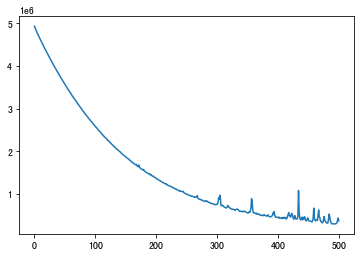

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 128)            66560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 198,531
Trainable params: 198,531
Non-trainable params: 0
_________________________________________________________________
None


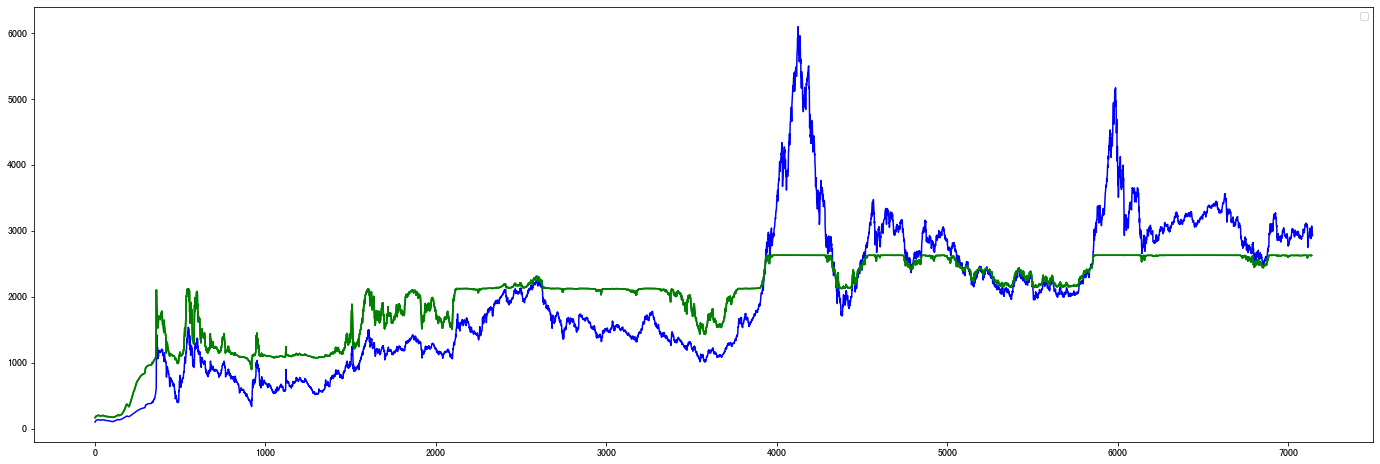

In [46]:
# 设置观测数据input(X)的步长（时间步）
timesteps_in = 3

# 设置output
timesteps_out = 3

epochs = 500
batch_size = 100

# 转化为可以用于监督学习的数据
train_x, label_y = get_train_set(data_set, timesteps_in=timesteps_in, timesteps_out=timesteps_out)

# 使用LSTM进行训练、预测
res = lstm_model(data_set, train_x, label_y, epochs, batch_size, timesteps_out=timesteps_out)


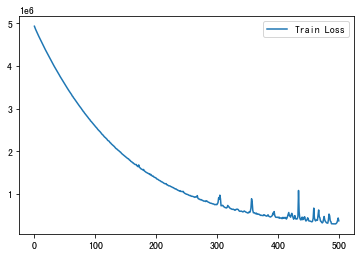

In [54]:
plt.plot(res.history['loss'], label='Train Loss')
plt.legend()
plt.show()

In [29]:
# !nvidia-smi

# Prophet

In [30]:
# 使用Prophet预测manning未来365天的页面流量
# 从2007年12月10日开始
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

Importing plotly failed. Interactive plots will not work.


In [36]:
# 读入数据集, use all columns
df = pd.read_csv('./shanghai_index_1990_12_19_to_2020_03_12.csv')

# 修改列名 Timestamp => ds, Price => y
df.rename(columns={'Timestamp':'ds', 'Price':'y'}, inplace=True)
df.head()

,ds,y,stock_volume,amount_volume
0,1990/12/19,99.98,1260,494000
1,1990/12/20,104.39,197,84000
2,1990/12/21,109.13,28,16000
3,1990/12/24,114.55,32,31000
4,1990/12/25,120.25,15,6000


In [37]:
df.tail()

,ds,y,stock_volume,amount_volume
7140,2020/3/6,3034.5113,362061533,3.77E+11
7141,2020/3/9,2943.2907,414560736,4.38E+11
7142,2020/3/10,2996.7618,393296648,4.25E+11
7143,2020/3/11,2968.5174,352470970,3.79E+11
7144,2020/3/12,2923.4856,307778457,3.28E+11


In [38]:
# 拟合模型
model = Prophet()
model.fit(df)

# 构建待预测日期数据框，periods = 365 代表除历史数据的日期外再往后推 365 天
future = model.make_future_dataframe(periods=365)

future.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
0,1990-12-19
1,1990-12-20
2,1990-12-21
3,1990-12-24
4,1990-12-25


In [39]:
future.tail()

,ds
7505,2021-03-08
7506,2021-03-09
7507,2021-03-10
7508,2021-03-11
7509,2021-03-12


In [40]:
# 预测数据集
forecast = model.predict(future)

forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [41]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
7505,2021-03-08,3173.083307,2530.604733,3742.498964
7506,2021-03-09,3170.352150,2558.481680,3713.998019
7507,2021-03-10,3172.968026,2602.869458,3753.446422
7508,2021-03-11,3170.030771,2566.443445,3749.031482
7509,2021-03-12,3169.992727,2571.005079,3730.951629


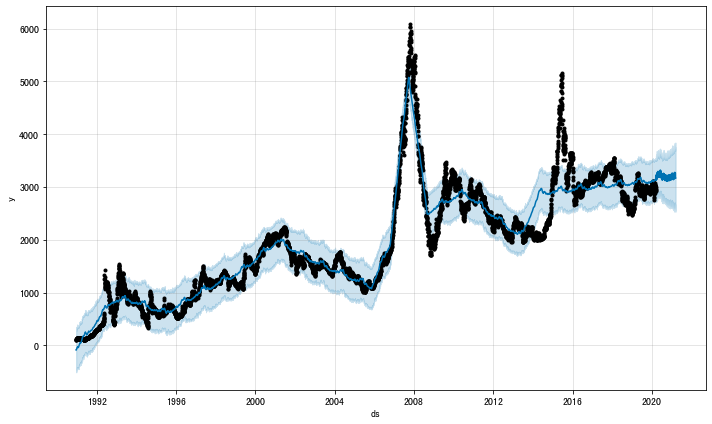

In [42]:
# 展示预测结果
model.plot(forecast)
plt.show()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

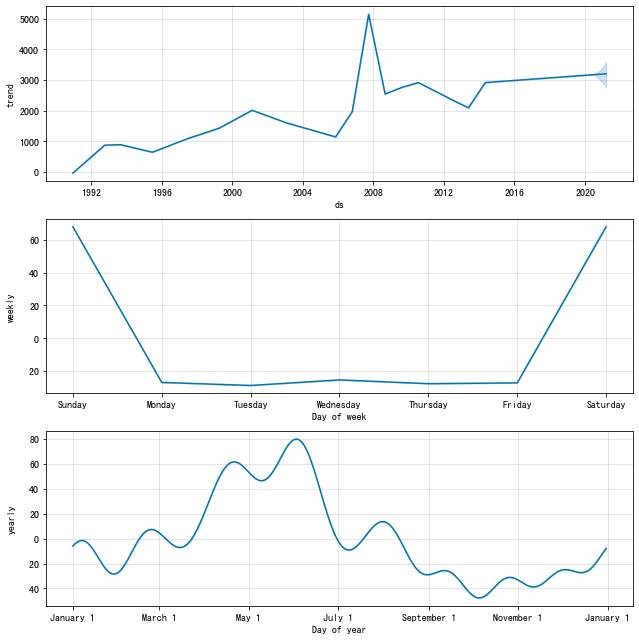

In [43]:
# 预测的成分分析绘图，展示预测中的趋势 （蓝色三角区为预测的未来日期y_hat和它的置信区间）、周效应和年度效应
model.plot_components(forecast)

forecast.columns